In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

# Quick start with chemfit

## The observed spectrum

In this tutorial, we will be using the observed spectrum of the star [TIC 198416624](https://simbad.cds.unistra.fr/simbad/sim-id?Ident=%40353205&Name=2MASS%20J17203417%2b5753319&submit=submit) ($V\approx 17.5$), observed with the Subaru/Prime Focus Spectrograph (PFS) on 2025-03-31. The spectrum can be found in `tutorials/TIC_198416624.pkl`:

In [2]:
f = open('TIC_198416624.pkl', 'rb')
spectrum = pickle.load(f)
f.close()

print(spectrum.keys())

dict_keys(['wl', 'flux', 'ivar'])


The spectrum was stored as a Python dictionary with three keys:

* `wl`: Wavelength vector in Å. Air wavelengths, observed (laboratory) frame of reference
* `flux`: Flux vector with arbitrary continuum normalization
* `ivar`: Inverse variance vector, i.e. $1/\sigma^2$ where $\sigma$ is the uncertainty in flux

Within each of those keys, there are two more sub-keys:

In [3]:
print(spectrum['wl'].keys())

dict_keys(['blue', 'red_mr'])


The star was observed simultaneously using the blue arm of the spectrograph (`blue`), and the red arm of the spectrograph in the medium resolution mode (`red_mr`). The cell below plots the blue spectrum near the $\mathrm{Mg\ I\ b}$ triplet:

(220000.0, 350000.0)

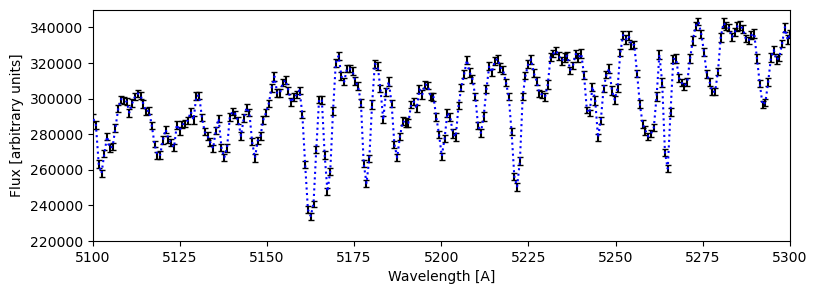

In [4]:
plt.figure(figsize = [9, 3])

plt.errorbar(spectrum['wl']['blue'], spectrum['flux']['blue'], yerr = spectrum['ivar']['blue'] ** -0.5,
             fmt = 'b:', capsize = 2, ecolor = 'k', zorder = 10)

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux [arbitrary units]')
plt.xlim(5100, 5300)
plt.ylim(2.2e5, 3.5e5)

## Instrument configuration

To proceed, `chemfit` needs to know the line spread function (i.e., resolution) of the instrument. It also needs to know which parts of the spectrum cannot be trusted, e.g., due to telluric absorption that has not been calibrated out. For a *typical PFS observation*, `chemfit` provides a default configuration preset which can be loaded with `chemfit.initialize()`:

In [5]:
import chemfit
chemfit.initialize('PFS')

The preset includes the approximate size of the Gaussian line spread function for all arms of the spectrograph...

In [6]:
print('Blue arm FWHM: {} A'.format(chemfit.settings['arms']['blue']['FWHM']))
print('Red arm, medium resolution FWHM: {} A'.format(chemfit.settings['arms']['red_mr']['FWHM']))

Blue arm FWHM: 2.07 A
Red arm, medium resolution FWHM: 1.368 A


...as well as a mask for regions of strong telluric absorption, which will be ignored by the fitter:

In [7]:
print('Ignored regions (A):', chemfit.settings['masks']['continuum'])

Ignored regions (A): [[6270, 6330], [6860, 6970], [7150, 7400], [7590, 7715], [8100, 8380], [8915, 9910], [10730, 12300], [12450, 12900]]


Note however that the line spread function varies from observation to observation, so ideally the settings need to be updated for each spectrum. `chemfit` allows the user to specify a single FWHM for the entire arm, or individual values for each wavelength bin.

## Determine the stellar parameters with GRIDFIT

A typical analysis with `chemfit` proceeds in two steps:

* `GRIDFIT` determines the fundamental stellar parameters of the spectrum ($T_\mathrm{eff}$, $\log(g)$, $[\mathrm{M/H}]$, $[\mathrm{\alpha/M}]$ and $[\mathrm{C/M}]$) by searching a large linearly interpolated grid of precomputed spectral models
* `LOCALFIT` then uses runtime spectral synthesis to determine the abundances of individual elements

To use `GRIDFIT`, `chemfit` must be pointed to the model grid file. The model grid is distributed in two versions: the full resolution grid (`fullres.h5`) stores spectral models at their native resolution ($R=300,000$), the binned grid (`binned.h5`) provides spectral models downsampled by a factor of $10$. At the resolution of PFS ($< 6000$), the binned grid is sufficient. To use the binned grid, create the following file in `settings/local/gridfit.py`:

```python
settings = {
    ### File name of the model grid  ###
    'grid_filename': '<path to binned.h5>',
}
```

`chemfit` can now be re-initialized as follows:

In [8]:
chemfit.initialize('gridfit', 'PFS')

Run the fit to determine the stellar parameters:

In [9]:
# Initial guesses for the parameters
# Most choices here are not important; however, the radial velocity (redshift) must be reasonably close to the
# expected value for the fit to converge. TIC 198416624 is a member of the Draco dwarf galaxy which is blueshifted
# by approximately 300 km/s
initial = {'teff': 4000, 'logg': 1.5, 'zscale': -1.5, 'alpha': 0.0, 'carbon': 0.0, 'redshift': -300}

# Run the fit
fit = chemfit.chemfit(spectrum['wl'], spectrum['flux'], spectrum['ivar'], initial = initial)

The best-fit parameters and their errors are now stored in the `fit` dictionary:

In [10]:
print('Best-fit parameters:', fit['fit'])
print('Best-fit errors:', fit['errors'])

Best-fit parameters: {'teff': 4303.026482032853, 'logg': 0.6653073923644154, 'zscale': -1.8511177715441467, 'alpha': 0.1047013112795289, 'carbon': -0.35819432225439685, 'redshift': -289.84466346445186}
Best-fit errors: {'zscale': 0.02310599529531825, 'alpha': 0.01742830438777867, 'teff': 13.691279835524625, 'logg': 0.04125253335241164, 'carbon': 0.023063418952812585, 'redshift': 0.3066599221965078}


Here `teff` is $T_\mathrm{eff}$ in Kelvin, `logg` is $\log(g)$, `zscale` is $[\mathrm{M/H}]$, `alpha` is $[\mathrm{\alpha/M}]$ ($\alpha$ includes $\mathrm{O}$, $\mathrm{Ne}$, $\mathrm{Mg}$, $\mathrm{Si}$, $\mathrm{S}$, $\mathrm{Ar}$, $\mathrm{Ca}$ and $\mathrm{Ti}$). The meaning of `carbon` is slightly less straightforward. It is related to $[\mathrm{C/M}]$, but rescaled such that $[\mathrm{C/M}]=0$ represents **not** the solar abundance, but the typical carbon abundance for a star with this $[\mathrm{M/H}]$ and $\log(g)$. To convert `carbon` into the real (solar-scaled) $[\mathrm{C/M}]$, you can use the following function:

In [11]:
print('[C/M] = {}'.format(chemfit.get_carbon_wrt_solar(fit['fit'])))

[C/M] = -0.8581943222543968


The best-fit model alongside other data is stored in `fit['extra']`. We can now plot our fit:

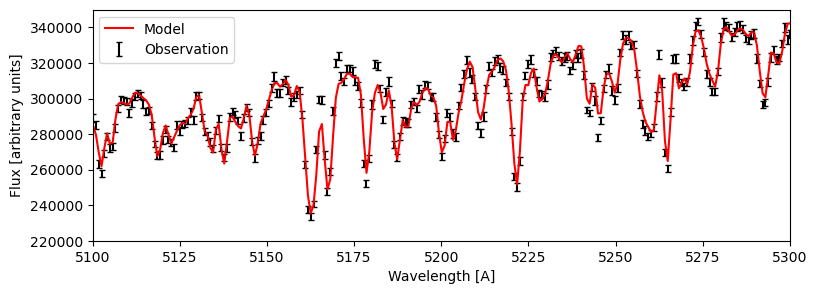

In [12]:
plt.figure(figsize = [9, 3])

# Plot the observed spectrum
plt.errorbar(fit['extra']['observed']['wl'], fit['extra']['observed']['flux'], yerr = fit['extra']['observed']['ivar'] ** -0.5,
             fmt = 'k,', capsize = 2, label = 'Observation')

# Plot the best-fit model
plt.plot(fit['extra']['model']['wl'], fit['extra']['model']['cont'] * fit['extra']['model']['flux'], 'r-', label = 'Model')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux [arbitrary units]')
plt.xlim(5100, 5300)
plt.ylim(2.2e5, 3.5e5)
plt.legend()

## Photometric priors

Purely spectroscopic determinations of $T_\mathrm{eff}$ are prone to degeneracy with metallicity and non-Local Thermodynamic Equilibrium (NLTE) effects. To obtain more reliable estimates of stellar parameters, it is recommended to include the measured color of the star in the fit. TIC 198416624 is listed in the Pan-STARRS PS1 (`II/349/ps1`) catalog under objId `177472601424051346`. It has $g$ and $i$ magnitudes of $17.9887\pm0.0081$ and $16.6563\pm 0.0035$, respectively. According to the [reddening map](https://irsa.ipac.caltech.edu/applications/DUST/), $E(B-V)\approx 0.0226$ along the line of sight. We can provide all of this information to `chemfit` to obtain more accurate estimates of the stellar parameters:

In [13]:
# g-i color and uncertainty
color = 17.9887 - 16.6563
e_color = np.sqrt(0.0081 ** 2.0 + 0.0035 ** 2.0)

# Reddening
E_BV = 0.0226

# The bands must be chosen from the filter transmission profiles stored in the 'bands' directory
# The user can add more filter profiles as needed
bands = '{}#{}'.format('PAN-STARRS_PS1_g.dat', 'PAN-STARRS_PS1_i.dat')

# Put everything together (also specify that the magnitude system is AB for Pan-STARRS)
phot = {bands: [color, e_color], 'reddening': E_BV, 'mag_system': 'ABMAG'}

# Re-run the fit
fit = chemfit.chemfit(spectrum['wl'], spectrum['flux'], spectrum['ivar'], initial = initial, phot = phot)

# Print the results
print('Best-fit parameters:', fit['fit'])
print('Best-fit errors:', fit['errors'])

Best-fit parameters: {'teff': 4317.074280696059, 'logg': 0.7111586178375836, 'zscale': -1.8286011010682877, 'alpha': 0.1048672543327543, 'carbon': -0.357175399958413, 'redshift': -289.8342310898248}
Best-fit errors: {'zscale': 0.01747178990472475, 'alpha': 0.01740757238021767, 'teff': 10.050733347179104, 'logg': 0.03189178404779312, 'carbon': 0.02295592804287514, 'redshift': 0.3074424921352834}


## Measuring the abundances of individual elements with LOCALFIT

Coming soon...